# Named Entity Recognition using RNN model
In Natural Language Processing (NLP) an Entity Recognition is one of the common problem. The entity is referred to as the part of the text that is interested in. In NLP, NER is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories such as location, organization, name and so on. 
Information about lables: 
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

        1. Total Words Count = 1354149 
        2. Target Data Column: Tag

#### Importing Libraries

In [1]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import WordPunctTokenizer
from sklearn import preprocessing
from tensorflow.keras import layers
import collections
import ipykernel
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import tensorflow as tf

In [2]:
#Reading the csv file
df = pd.read_csv('ner_dataset.csv', encoding = "ISO-8859-1")

In [3]:
#Display first 10 rows
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 1748,the,NN,O
freq,1,52573,145807,887908


#### Observations : 
* There are total 47959 sentences in the dataset.
* Number unique words in the dataset are 35178.
* Total 17 lables (Tags).

In [5]:
#Displaying the unique Tags
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [6]:
#Checking null values, if any.
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

There are lots of missing values in 'Sentence #' attribute. So we will use pandas fillna technique and use 'ffill' method which propagates last valid observation forward to next.

In [7]:
df = df.fillna(method = 'ffill')

In [8]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [9]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [10]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


Getting all the sentences in the dataset.

In [11]:
sentences = getter.sentences

In [12]:
yt = []
for tagged in sentences:
    yt.append([tag for _,_, tag in tagged])

In [13]:
sentencesOnly = [" ".join([s[0] for s in sent]) for sent in sentences]
sentencesOnly = np.array(sentencesOnly)
sentencesOnly[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [14]:
len_sent = []
tok = WordPunctTokenizer()
for sent in sentencesOnly:
    len_sent.append(len(tok.tokenize(sent)))
print("Panjang maximum twitter:",np.max(len_sent))


Panjang maximum twitter: 128


In [15]:
print(len(sentences))
labels = []
for t in sentences:
    for tt in t:
        labels.append(tt[2])
print(len(labels))
labels = np.array(labels)
print(labels[0])

47959
1048575
O


In [16]:
le = preprocessing.LabelEncoder()
le.fit(list(set(labels)))
print(list(le.classes_))
num_labels = [le.transform(pere) for pere in yt]
num_labels = np.array(num_labels)
num_labels = tf.keras.preprocessing.sequence.pad_sequences(num_labels, maxlen=128, padding='post', value=17)
padY = tf.keras.preprocessing.sequence.pad_sequences(yt, maxlen=128, padding='post', value='<PAD>', dtype=object)

['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O']


In [17]:
print(num_labels[0])
print(padY[0])

[16 16 16 16 16 16  2 16 16 16 16 16  2 16 16 16 16 16  3 16 16 16 16 16
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17]
['O' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O'
 'O' 'O' 'B-gpe' 'O' 'O' 'O' 'O' 'O' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PA

In [18]:
x_train, x_test, y_train, y_test = train_test_split(sentencesOnly, num_labels, test_size=0.1, random_state=42)

In [19]:
y_train = tf.keras.utils.to_categorical(y_train, 18)
y_test = tf.keras.utils.to_categorical(y_test, 18)

In [20]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

43163
4796
43163
4796


In [21]:
t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(np.array(x_train))

In [22]:
vocab_size = len(t.word_index) + 1

In [23]:
max_length = 128

In [24]:
encodedXTrain = t.texts_to_sequences(x_train)
encodedXTest = t.texts_to_sequences(x_test)
padXTrain = tf.keras.preprocessing.sequence.pad_sequences(encodedXTrain, maxlen=max_length, padding='post')
padXTest = tf.keras.preprocessing.sequence.pad_sequences(encodedXTest, maxlen=max_length, padding='post')
print('Train:')
print(padXTrain)
print('Test:')
print(padXTest)

Train:
[[ 2760    33  2995 ...     0     0     0]
 [    1   534     2 ...     0     0     0]
 [    1   275    99 ...     0     0     0]
 ...
 [ 2542    66    37 ...     0     0     0]
 [ 5240  2968     1 ...     0     0     0]
 [  219    16 26894 ...     0     0     0]]
Test:
[[    1   144   498 ...     0     0     0]
 [    1   901    10 ...     0     0     0]
 [    1  2513    17 ...     0     0     0]
 ...
 [  748 19354 10076 ...     0     0     0]
 [   44    23    16 ...     0     0     0]
 [   30  5932  3652 ...     0     0     0]]


In [25]:
print(padXTrain.shape, y_train.shape)
print(padXTest.shape, y_test.shape)

(43163, 128) (43163, 128, 18)
(4796, 128) (4796, 128, 18)


In [26]:
w2vEmbedding = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True,limit=1000000)

In [27]:
def getEmbedVector(embedModel, word):
    embedVec = 2 * np.random.rand(embedModel.vector_size,) - 1
    if word in embedModel:
        embedVec = embedModel[word]
    elif word.lower() in embedModel:
        embedVec = embedModel[word.lower()]
    return embedVec

In [28]:
print(getEmbedVector(w2vEmbedding, 'asddgadf'))

[ 6.83582945e-01  1.90313140e-01 -6.52271118e-01 -6.07663526e-01
  7.32153212e-01  5.36527606e-01  9.36436036e-01  4.79274079e-01
 -9.33784013e-01 -9.74943067e-02 -5.89423155e-01 -6.19748573e-01
 -4.57974689e-01 -4.45734023e-01 -2.44878226e-01  3.69559316e-01
 -8.13648579e-01 -9.26721581e-01  7.89797209e-01  1.30698320e-01
  8.09137989e-01  9.82154704e-01 -7.45041235e-01  6.78660212e-02
 -2.20383494e-01 -1.61403713e-02  2.58509635e-01 -9.40712408e-01
 -8.18876509e-01 -4.23594282e-01  4.19056889e-01  8.84554970e-01
  5.35854393e-01 -5.30250082e-01  3.97458851e-01  5.45040980e-01
  6.73143020e-01  5.08487263e-01  8.96323714e-01  2.80718251e-01
  8.16897464e-01  1.89907216e-01  3.30743558e-01 -7.87503185e-01
  6.72368095e-01 -7.29727309e-01  8.31753739e-01 -7.26829929e-01
  1.31924111e-01  8.09060585e-01 -8.23699676e-01  9.82098076e-01
  1.14470554e-01  1.92863324e-01 -5.93421330e-01 -5.97465667e-01
  3.23718972e-01 -6.81036536e-01 -8.18765332e-01 -8.02610398e-01
  7.56654274e-01  3.08088

In [29]:
def get_weight_matrix(embedModel, vocab):
    vSize = len(vocab) + 1
    weight_matrix = np.zeros((vSize, embedModel.vector_size))
    for word, i in vocab.items():
        weight_matrix[i] = getEmbedVector(embedModel, word)
    return weight_matrix

In [30]:
embedding_vectors = get_weight_matrix(w2vEmbedding, t.word_index)
embedding_layer = layers.Embedding(vocab_size, w2vEmbedding.vector_size,
                                   weights=[embedding_vectors],
                                   input_length=max_length, trainable=False)

In [31]:
RNNModel = tf.keras.models.Sequential()
RNNModel.add(embedding_layer)
RNNModel.add(layers.SimpleRNN(128,return_sequences=True))
RNNModel.add(layers.TimeDistributed(layers.Dense(18, activation='softmax')))
RNNModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 300)          8068500   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128, 128)          54912     
_________________________________________________________________
time_distributed (TimeDistri (None, 128, 18)           2322      
Total params: 8,125,734
Trainable params: 57,234
Non-trainable params: 8,068,500
_________________________________________________________________


In [32]:
RNNModel.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.RMSprop(),
                metrics = ['accuracy'])

In [33]:
epochs = 20
batch_size = 512
history = RNNModel.fit(padXTrain, y_train, epochs = epochs, batch_size = batch_size,
                      validation_split=0.1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/20
38846/38846 [==============================] - 9s 240us/sample - loss: 0.4159 - accuracy: 0.8999 - val_loss: 0.1358 - val_accuracy: 0.9661
Epoch 2/20
38846/38846 [==============================] - 7s 191us/sample - loss: 0.1234 - accuracy: 0.9683 - val_loss: 0.1168 - val_accuracy: 0.9690
Epoch 3/20
38846/38846 [==============================] - 7s 190us/sample - loss: 0.1094 - accuracy: 0.9700 - val_loss: 0.1160 - val_accuracy: 0.9686
Epoch 4/20
38846/38846 [==============================] - 7s 187us/sample - loss: 0.1030 - accuracy: 0.9708 - val_loss: 0.1031 - val_accuracy: 0.9706
Epoch 5/20
38846/38846 [==============================] - 7s 191us/sample - loss: 0.0994 - accuracy: 0.9715 - val_loss: 0.1000 - val_accuracy: 0.9711
Epoch 6/20
38846/38846 [==============================] - 7s 189us/sample - loss: 0.0984 - accuracy: 0.9717 - val_loss: 0.0988 - val_accuracy: 0.9713
Epoch 7/20
38846/38846 [===========================

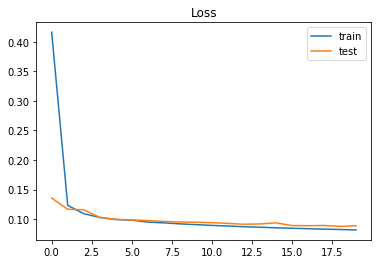

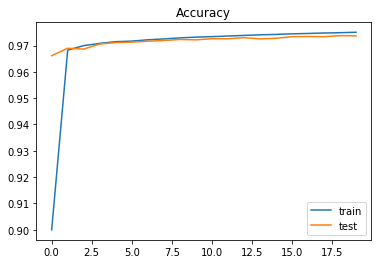

In [34]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [35]:
accr = RNNModel.evaluate(padXTest, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4796/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test set
  Loss: 0.093
  Accuracy: 0.973


In [36]:
RNNModel.save('RNNforNER.h5')